In [1]:
import os
import numpy as np
import pandas as pd
import dask.dataframe as dd
import matplotlib.pyplot as plt
import seaborn as sns 

plt.rcParams['figure.dpi'] = 120
sns.set_style('whitegrid')

In [2]:
%%time
file_path = '../data/cleaned/cleaned_taxi_data.csv'
taxi_df = dd.read_csv(file_path)
taxi_df = taxi_df.persist()
taxi_df.head()

CPU times: total: 38 s
Wall time: 20.2 s


,booking_id,name,driver_age,gender,car_model,car_make_year,accuracy,direction,acceleration_x,acceleration_y,...,MA (m/s^2),gyro_x,gyro_y,gyro_z,MAV (rad/s),second,duration (mins),speed (km/h),rating,safety_label
0,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-1.706207,-9.270792,...,9.503762,-0.028965,-0.032652,0.015390,0.046282,2.0,0.03,0.822436,4.0,0
1,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-1.416705,-9.548032,...,9.830320,-0.022413,0.005049,-0.025753,0.034511,3.0,0.05,0.822436,4.0,0
2,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.346924,-9.532629,...,9.614707,0.014962,-0.050033,0.025118,0.057949,9.0,0.15,0.822436,4.0,0
3,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.600986,-9.452029,...,9.713747,0.004548,-0.011713,-0.004078,0.013210,11.0,0.18,0.822436,4.0,0
4,0,Lilia,48,Male,Mercedes-Benz,2013,8.0,South East,-0.597546,-9.863403,...,10.022063,-0.000401,0.000315,-0.009830,0.009843,12.0,0.20,0.822436,4.0,0


In [3]:
taxi_df.compute().info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7469656 entries, 0 to 327613
Data columns (total 21 columns):
 #   Column           Non-Null Count    Dtype  
---  ------           --------------    -----  
 0   booking_id       7469656 non-null  int64  
 1   name             7469656 non-null  object 
 2   driver_age       7469656 non-null  int64  
 3   gender           7469656 non-null  object 
 4   car_model        7469656 non-null  object 
 5   car_make_year    7469656 non-null  int64  
 6   accuracy         7351631 non-null  float64
 7   direction        7469656 non-null  object 
 8   acceleration_x   7364539 non-null  float64
 9   acceleration_y   7346553 non-null  float64
 10  acceleration_z   7370520 non-null  float64
 11  MA (m/s^2)       7148013 non-null  float64
 12  gyro_x           7336398 non-null  float64
 13  gyro_y           7329944 non-null  float64
 14  gyro_z           7404168 non-null  float64
 15  MAV (rad/s)      7136620 non-null  float64
 16  second           74

In [4]:
taxi_df.columns

Index(['booking_id', 'name', 'driver_age', 'gender', 'car_model',
       'car_make_year', 'accuracy', 'direction', 'acceleration_x',
       'acceleration_y', 'acceleration_z', 'MA (m/s^2)', 'gyro_x', 'gyro_y',
       'gyro_z', 'MAV (rad/s)', 'second', 'duration (mins)', 'speed (km/h)',
       'rating', 'safety_label'],
      dtype='object')

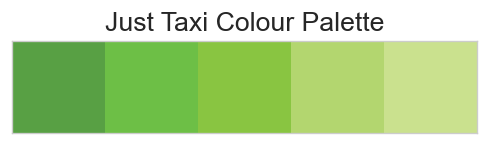

In [5]:
# set font family
hfont = {'fontname':'Gill Sans MT'}

# set colour palette for better visualisations
palette = ['#58A044', '#6DBF46', '#89C541', '#B3D66F', '#CAE18E']

sns.palplot(palette)
plt.title('Just Taxi Colour Palette', fontsize=16)
plt.grid(False)
plt.show()

## Ride Safety Ratios

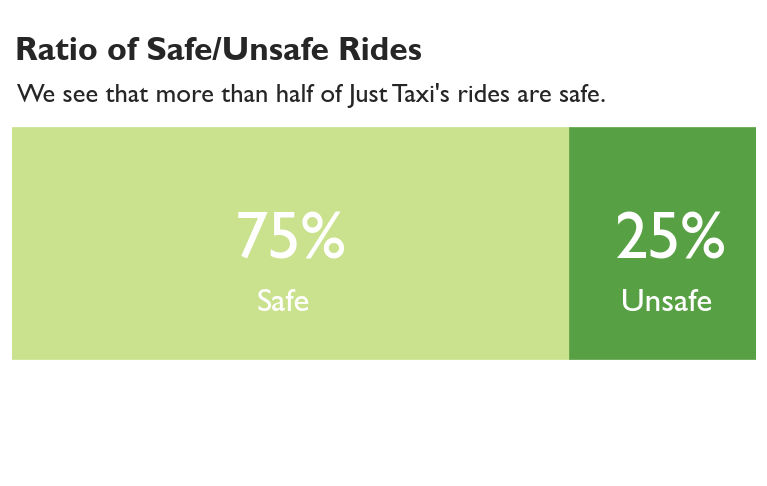

In [6]:
safety_labels = taxi_df.groupby('booking_id').first()['safety_label']
safety_ratios = (safety_labels.compute().value_counts() / len(safety_labels)).round(2)
safety_ratios.index = ['Safe', 'Unsafe']
safety_ratios = safety_ratios.to_frame().T

# ratio plot of safety label
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

axes.barh(safety_ratios.index, safety_ratios['Safe'], color=palette[-1], height=0.5, label='Safe', edgecolor=palette[-1])
axes.barh(safety_ratios.index, safety_ratios['Unsafe'], left=safety_ratios['Safe'], color=palette[0], height=0.5, label='Unsafe', edgecolor=palette[0])

# set y-axis limits
axes.set_ylim(-0.5, 0.5)
axes.set_ylabel('')
axes.set_yticklabels([])

axes.set_xlim(0, 1)
axes.set_xticklabels([])


# safety percentage labels
for i, v in enumerate(safety_ratios['Safe']):
    axes.text(v / 2, i, str(int(v * 100)) + '%', color='white', ha='center', va='center', fontsize=40, **hfont)
    axes.text(v / 2 - 0.01, i - 0.13, 'Safe', color='white', ha='center', va='center', fontsize=20, **hfont)
    

for i, v in enumerate(safety_ratios['Unsafe']):
    axes.text(v / 2 + safety_ratios['Safe'][i] + 0.01, i, str(int(v * 100)) + '%', color='white', ha='center', va='center', fontsize=40, **hfont)
    axes.text(v / 2 + safety_ratios['Safe'][i] + 0.005, i - 0.13, 'Unsafe', color='white', ha='center', va='center', fontsize=20, **hfont)

# set title and annotate
fig.text(0.34, .8, 'Ratio of Safe/Unsafe Rides', fontsize=20, fontweight='bold',  ha='center', **hfont)
fig.text(0.13, 0.73, "We see that more than half of Just Taxi's rides are safe.", fontsize=16, **hfont)  

axes.grid(False)
sns.despine(right=True, top=True, left=True, bottom=True, ax=axes)

plt.show()

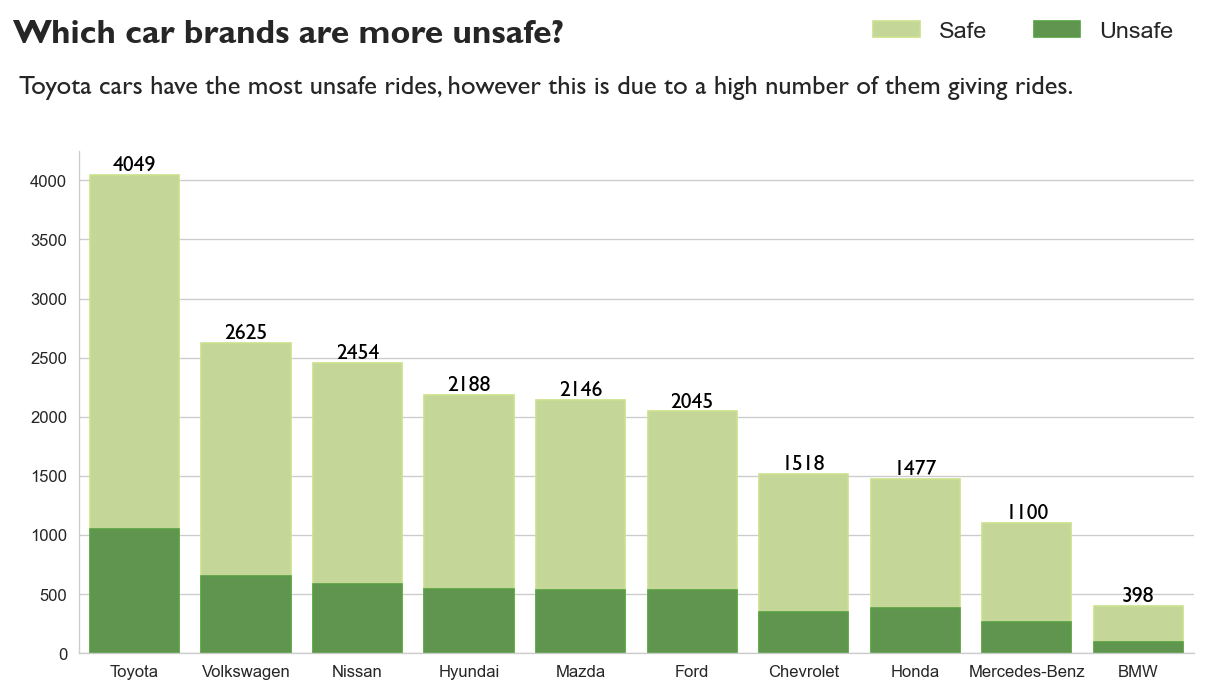

In [7]:
# per booking, what are each car brand's safety ratios?
rides_per_booking = taxi_df.groupby('booking_id').first()

# get number of each car model in dataset
model_counts = rides_per_booking['car_model'].value_counts().compute()

# get number of each car model in safe/unsafe rides
safe_model_counts = rides_per_booking[rides_per_booking['safety_label'] == 0]['car_model'].value_counts().compute()
unsafe_model_counts = rides_per_booking[rides_per_booking['safety_label'] == 1]['car_model'].value_counts().compute()

# get safety ratios
safe_model_ratios = (safe_model_counts / model_counts).round(2)
unsafe_model_ratios = (unsafe_model_counts / model_counts).round(2)

# get safety ratios in dask dataframe
safe_model_ratios = dd.from_pandas(safe_model_ratios, npartitions=1)
unsafe_model_ratios = dd.from_pandas(unsafe_model_ratios, npartitions=1)

# store both safety ratios in one dask dataframe
model_safety_ratios = dd.concat([safe_model_ratios, unsafe_model_ratios], axis=1)
model_safety_ratios.columns = ['safe', 'unsafe']

# store model counts in dask dataframe
model_counts = dd.from_pandas(model_counts, npartitions=1)
# join model counts and safety ratios and rename column to 'count'
model_safety_ratios = model_safety_ratios.join(model_counts, how='inner').rename(columns={'car_model': 'count'})

sorted_model_df = model_safety_ratios.compute().sort_values('count', ascending=False)

colors = [palette[-1] for _ in range(len(sorted_model_df))]

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

sns.barplot(x=list(sorted_model_df.index), y=sorted_model_df['count'], palette=colors, edgecolor=colors, ax=axes, label='Safe')
sns.barplot(x=list(sorted_model_df.index), y=sorted_model_df['unsafe'] * sorted_model_df['count'], color=palette[0], edgecolor=palette[0], ax=axes, label='Unsafe')

# label tiotal number of rides per car model
for i, v in enumerate(sorted_model_df['count']):
    axes.text(i, v + 80, str(v), color='black', ha='center', va='center', fontsize=13, **hfont)

axes.set_xlabel('')
axes.set_ylabel('')

# set title and annotate
fig.text(0.23, 0.91, 'Which car brands are more unsafe?', fontsize=20, fontweight='bold',  ha='center', **hfont)
fig.text(0.006, 0.84, "Toyota cars have the most unsafe rides, however this is due to a high number of them giving rides.", fontsize=16, **hfont)  

axes.legend(loc='upper right', fontsize=14, frameon=False, ncol=2, bbox_to_anchor=(1, 1.3))
sns.despine(right=True, top=True, left=False, bottom=False)
plt.tight_layout()
plt.show()

In [8]:
# car make year?

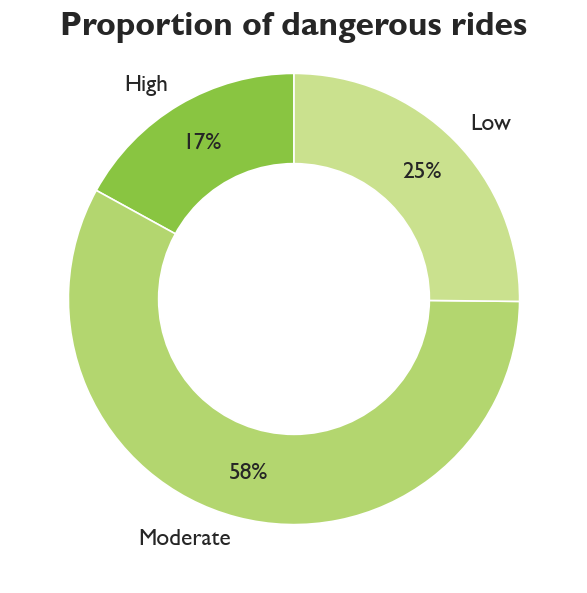

In [9]:
driver_safety_ratio = taxi_df.groupby('booking_id').first()
driver_safety_ratio = driver_safety_ratio.groupby('name')['safety_label'].value_counts().compute()
driver_safety_ratio = driver_safety_ratio.to_frame().unstack()  # convert to df and unstack
driver_safety_ratio.columns = driver_safety_ratio.columns.droplevel(0)  # remove multiindex
driver_safety_ratio.columns = ['safe', 'unsafe']  # rename columns
driver_safety_ratio['total'] = driver_safety_ratio['safe'] + driver_safety_ratio['unsafe']  # add total column

unsafe_pct = (driver_safety_ratio['unsafe'] / driver_safety_ratio['total']).round(2)
unsafe_pct = unsafe_pct.sort_values(ascending=False)

# group unsafe pct into buckets and store in dask dataframe
unsafe_df = dd.from_pandas(unsafe_pct, npartitions=1)
unsafe_df = unsafe_df.to_frame().reset_index()
unsafe_df.columns = ['name', 'unsafe_pct']
unsafe_df['group'] = unsafe_df['unsafe_pct'].apply(
    lambda x: 
        'High' if x >= 0.29 else 
        ('Moderate' if x >= 0.23
        else 'Low'), 
        meta=('group', 'object')
)
unsafe_df = unsafe_df.set_index('name')

unsafety_groups = unsafe_df['group'].value_counts()
unsafety_groups = unsafety_groups.to_frame()
# reorder groups
unsafety_groups = unsafety_groups.compute().reindex(['High', 'Moderate', 'Low'])

# donut chart of unsafe groups
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))

# plot donut chart
axes.pie(unsafety_groups['group'], labels=unsafety_groups.index, colors=palette[-3:], autopct='%1.0f%%', startangle=90, pctdistance=0.80, textprops={'fontsize': 14, **hfont})
centre_circle = plt.Circle((0, 0), 0.60, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# set title and annotate
fig.text(0.5, 0.94, 'Proportion of dangerous rides', fontsize=20, fontweight='bold',  ha='center', **hfont)
# fig.text(0.2, 0.85, "Most drivers have a moderate amount of unsafe rides within the dataset.", fontsize=14, **hfont)

sns.despine(right=True, top=True, left=True, bottom=True)
plt.tight_layout()
plt.show()

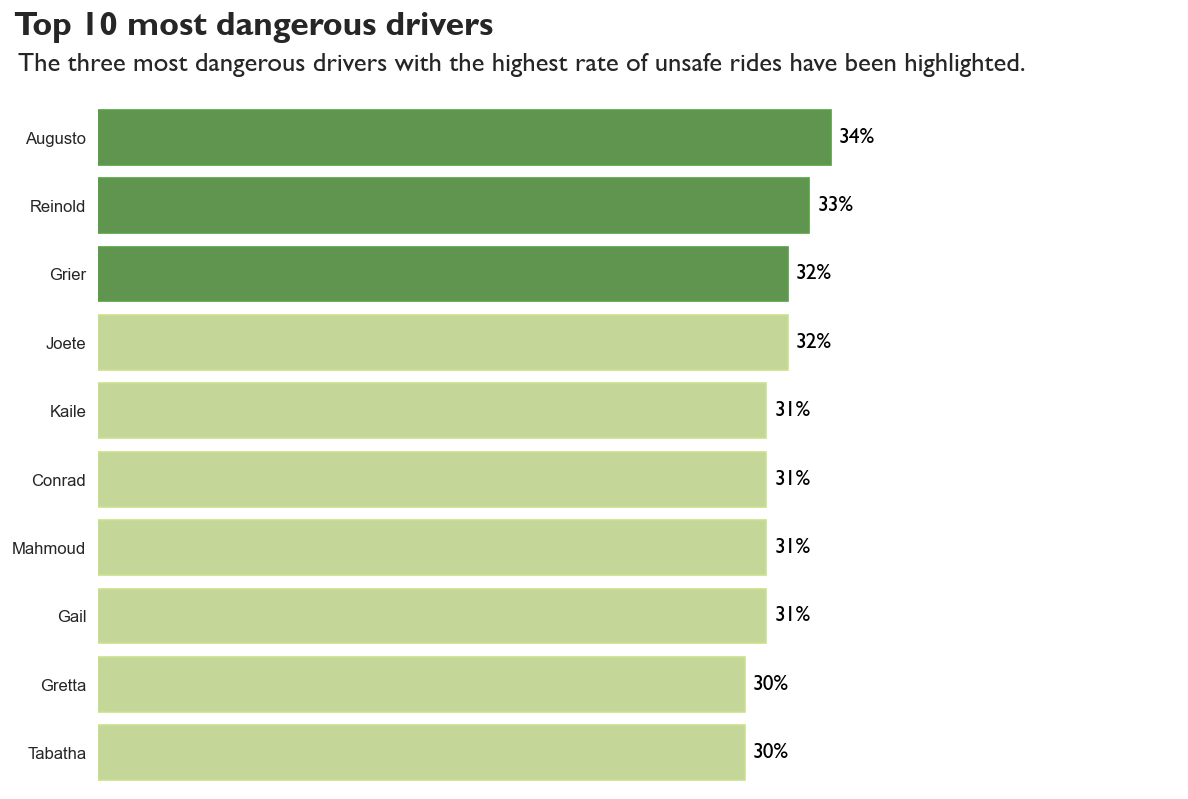

In [10]:
driver_safety_ratio['danger_rate'] = (driver_safety_ratio['unsafe'] / driver_safety_ratio['total']).round(2)

# top 10 drivers with highest number/percentage of unsafe rides
top_10_unsafe_drivers = driver_safety_ratio.sort_values('danger_rate', ascending=False).head(10)

colours = [palette[-1] for _ in range(len(top_10_unsafe_drivers))]
colors[0] = colors[1] = colors[2] = palette[0]

# plot barh chart
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))

sns.barplot(x=top_10_unsafe_drivers['danger_rate'], y=top_10_unsafe_drivers.index, palette=colors, edgecolor=colors, ax=axes)

# label percentage of unsafe rides
for i, v in enumerate(top_10_unsafe_drivers['danger_rate']):
    axes.text(v + 0.012, i, f'{int(v * 100)}%', color='black', ha='center', va='center', fontsize=13, **hfont)

axes.set_xlabel('')
axes.set_xticks([])
axes.set_ylabel('')
axes.set_xlim(0, 0.5)
axes.grid(False)

# set title and annotate
fig.text(0.216, 1.07, 'Top 10 most dangerous drivers', fontsize=20, fontweight='bold',  ha='center', **hfont)
fig.text(0.02, 1.02, "The three most dangerous drivers with the highest rate of unsafe rides have been highlighted. ", fontsize=16, **hfont)


sns.despine(right=True, top=True, left=True, bottom=True)
plt.tight_layout()
plt.show()

In [11]:
age_by_safety = taxi_df.groupby('booking_id')[['driver_age', 'safety_label']].first()

age_by_safety = age_by_safety.groupby('driver_age')['safety_label'].value_counts()
age_by_safety = age_by_safety.to_frame().compute().unstack()
age_by_safety.columns = age_by_safety.columns.droplevel(0)
age_by_safety.columns = ['safe', 'unsafe']
age_by_safety['total'] = age_by_safety['safe'] + age_by_safety['unsafe']
age_by_safety['safe_pct'] = (age_by_safety['safe'] / age_by_safety['total']).round(2)
age_by_safety['unsafe_pct'] = (age_by_safety['unsafe'] / age_by_safety['total']).round(2)
age_by_safety.reset_index(inplace=True)

# age groups: 
# 27 to 29, 
# 30 to 35, 
# 36 to 40
# 41 to 45
# 46 to 50
age_by_safety['age_group'] = age_by_safety['driver_age'].apply(
    lambda x:
        '27 to 29' if x >= 27 and x <= 29 else
        ('30 to 35' if x >= 30 and x <= 35 else
        ('36 to 40' if x >= 36 and x <= 40 else
        ('41 to 45' if x >= 41 and x <= 45 else
        ('46 to 50'))))
)

age_by_safety = age_by_safety.groupby('age_group')[['safe','unsafe']].sum()
age_by_safety['safe_pct'] = (age_by_safety['safe'] / age_by_safety['safe'].sum()).round(2)
age_by_safety['unsafe_pct'] = (age_by_safety['unsafe'] / age_by_safety['unsafe'].sum()).round(2)
age_by_safety

,safe,unsafe,safe_pct,unsafe_pct
age_group,,,,
27 to 29,1418,478,0.09,0.10
30 to 35,3322,1100,0.22,0.22
36 to 40,2985,969,0.20,0.19
41 to 45,4205,1469,0.28,0.29
46 to 50,3077,977,0.21,0.20


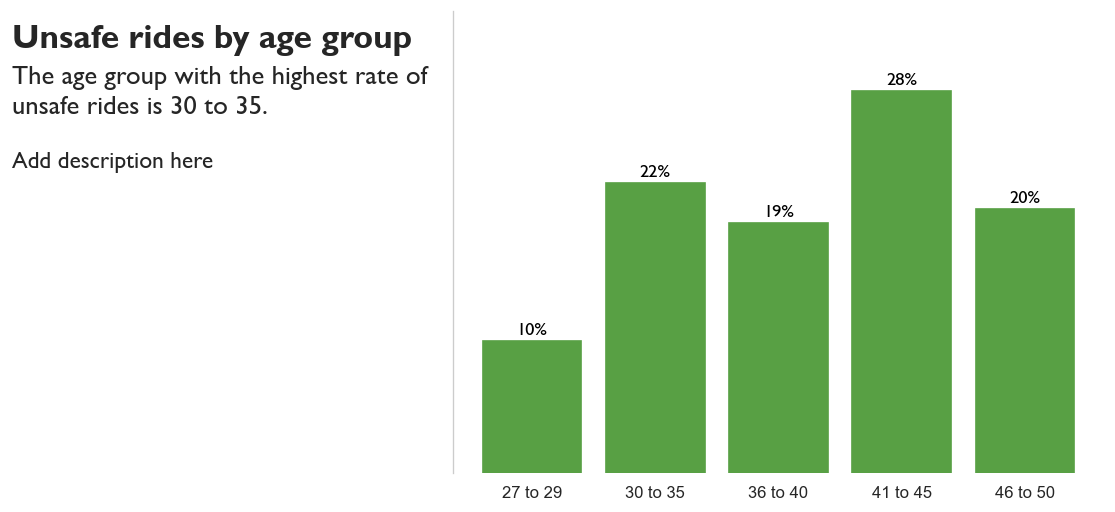

In [99]:
# remove safe only plot unsafe
unsafe_pct = age_by_safety['unsafe_pct']

fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(7, 5))

axes.bar(unsafe_pct.index, unsafe_pct, width=.8, color=palette[0], edgecolor=palette[0])

# annote unsafe and convert values toto positive
for i, v in enumerate(unsafe_pct):
    axes.text(i, v + 0.008, f'{int(v * 100)}%', color='black', ha='center', va='center', fontweight='light', fontsize=11, **hfont)

axes.set_yticks([])
axes.set_ylim(0, 0.35)

# set title and annotate
fig.text(-0.4, 0.82, 'Unsafe rides by age group', fontsize=20, fontweight='bold',  ha='left', **hfont)
fig.text(-0.4, 0.76, "The age group with the highest rate of", fontsize=16, ha='left', **hfont)
fig.text(-0.4, 0.71, "unsafe rides is 30 to 35.", fontsize=16, ha='left', **hfont)

fig.text(-0.4, 0.62, "Add description here", fontsize=14, ha='left', **hfont)

axes.grid(False)
sns.despine(right=True, top=True, left=False, bottom=True)
plt.show()


In [13]:
# speed